In [12]:
import torch
import numpy as np
import torch.nn as nn
from torch.nn import Sequential
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix

[tensor(5), tensor(5), tensor(4), tensor(4), tensor(3), tensor(5), tensor(4), tensor(6), tensor(5), tensor(5), tensor(5), tensor(5), tensor(2), tensor(9), tensor(6), tensor(4)]


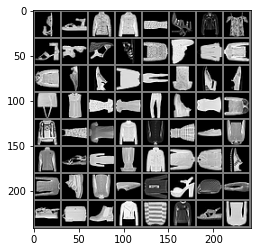

In [13]:
# 设置数据转换方式
transform = transforms.Compose([
    transforms.ToTensor(),  # 把数据转换为张量（Tensor）
    transforms.Normalize(  # 标准化，即使数据服从期望值为 0，标准差为 1 的正态分布
        mean=[0.5, ],  # 期望
        std=[0.5, ]  # 标准差
    )
])

class myDataset(Dataset):
    def __init__(self, xpath, ypath, transform, train=True):
        super(myDataset, self).__init__()
        self.x = np.load(xpath).transpose().reshape(-1, 28, 28, 1)
        self.y = np.load(ypath).transpose().reshape(-1, 1)
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        x = self.transform(self.x[index])
        y = int(self.y[index])
        data = (x, y)
        return data

train_x = np.load('train_x.npy')
unlabeled_x = np.load('unlabeled_x.npy')
addtrain_x = np.load('addtrain_x.npy')
train_x = np.hstack((train_x, unlabeled_x, addtrain_x))
np.save('train_x2', train_x)

train_y = np.load('train_y.npy')
unlabeled_y = np.load('unlabeled_y.npy')
addtrain_y = np.load('addtrain_y.npy')
train_y = np.argmax(train_y, axis = 0)
addtrain_y = np.argmax(addtrain_y, axis = 0)
train_y = np.hstack((train_y, unlabeled_y, addtrain_y))
np.save('train_y2', train_y)

test_y = np.load('test_y.npy')
test_y = np.argmax(test_y, axis = 0)
np.save('test_y2', test_y)

data_train = myDataset(xpath='./train_x2.npy', ypath='./train_y2.npy', transform=transform, train=True)
data_test = myDataset(xpath='./test_x.npy', ypath='./test_y2.npy', transform=transform, train=False)

# 数据装载
dataloader_train = DataLoader(dataset=data_train, batch_size=64, shuffle=True)# 训练集装载

dataloader_test = DataLoader(dataset=data_test, batch_size=64, shuffle=True)# 数据集装载

# 数据预览
images, labels = next(iter(dataloader_train))
img = make_grid(images)
img = img.numpy().transpose(1, 2, 0)
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
img = img * std + mean
print([labels[i] for i in range(16)])
plt.imshow(img)
plt.show()

In [14]:
# 构建卷积神经网络
class CNN(nn.Module):  # 从父类 nn.Module 继承
    def __init__(self):  # 相当于 C++ 的构造函数
        # super() 函数是用于调用父类(超类)的一个方法，是用来解决多重继承问题的
        super(CNN, self).__init__()

        # 第一层卷积层。Sequential(意为序列) 括号内表示要进行的操作
        self.conv1 = Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),# 归一化处理
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)# 池化层
        )

        # 第二卷积层
        self.conv2 = Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),# 归一化处理
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)# 池化层
        )

        # 全连接层（Dense，密集连接层）
        self.dense = Sequential(
            nn.Linear(7 * 7 * 128, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 10)
        )

    def forward(self, x):  # 正向传播
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x = x2.view(-1, 7 * 7 * 128)
        x = self.dense(x)
        return x

In [ ]:
# 训练和参数优化
max_epoch = 50
batch_size = 64
alpha = 0.0001

# 定义求导函数
def get_Variable(x):
    return torch.autograd.Variable(x)  # Pytorch 的自动求导

# 定义网络
cnn = CNN()

# 设置损失函数为交叉熵损失函数
cost_func = nn.CrossEntropyLoss()

# 设置优化器为 Adam 优化器
optimizer = torch.optim.Adam(cnn.parameters(), lr = alpha)

# 训练
for epoch in range(max_epoch):
    cost = 0.0  # 一个 epoch 的损失
    correct = 0.0  # 准确率
    for data in dataloader_train:
        # DataLoader 返回值是一个 batch 内的图像和对应的 label
        X_train, y_train = data
        X_train, y_train = get_Variable(X_train), get_Variable(y_train)
        outputs = cnn(X_train)
        _, pred = torch.max(outputs.data, 1)
        # 后面的参数代表降低 outputs.data 的维度 1 个维度再输出
        # 第一个返回值是张量中最大值，第二个返回值是最大值索引
        # 梯度下降
        optimizer.zero_grad() # 梯度置零
        loss = cost_func(outputs, y_train) # 求损失
        loss.backward() # 反向传播
        optimizer.step() # 更新所有梯度

        cost += loss.item() # 此处 item() 表示返回每次的 loss 值
        correct += torch.sum(pred == y_train.data)

    testing_correct = 0.0

    for data in dataloader_test:
        X_test, y_test = data
        X_test, y_test = get_Variable(X_test), get_Variable(y_test)
        outputs = cnn(X_test)
        _, pred = torch.max(outputs, 1)
        testing_correct += torch.sum(pred == y_test.data)
    print("epoch = {}  cost: {:.4f}  train accuracy: {:.4f}%  test accuracy: {:.4f}%".format(
        epoch, cost / len(data_train), 100 * correct / len(data_train),
        100 * testing_correct / len(data_test)))
 
torch.save(cnn, 'network.pth')

In [15]:
cnn = torch.load('model.pth')
data_final = myDataset(xpath='./test_x.npy', ypath='./final_x.npy', transform = transform, train = False)
dataloader_final = DataLoader(dataset=data_final, batch_size = 5000, shuffle = False)
for data in dataloader_final:
    data_final_x, _ = data
    data_final_y = cnn(data_final_x)
    _, data_final_y = torch.max(data_final_y, 1)
print(data_final_y)
outputs = np.array(data_final_y)
# outputs = np.expand_dims(outputs, 0)
print(outputs)
np.save('aaa.npy', outputs)

# cnn = torch.load('network.pth')
# data_unlabel = myDataset(xpath='./unlabeled_x.npy', ypath='./unlabeled_x.npy', transform=transform, train=False)
# dataloader_unlabel = DataLoader(dataset=data_unlabel, batch_size=5000, shuffle=False)
# for data in dataloader_unlabel:
#     data_unlabel_x, _ = data
#     data_unlabel_y = cnn(data_unlabel_x)
#     _, data_unlabel_y = torch.max(data_unlabel_y, 1)
# outputs = np.array(data_unlabel_y)
# outputs = np.expand_dims(outputs, 0)
# print(outputs)
# np.save('unlabeled_y.npy', outputs)

tensor([2, 6, 7,  ..., 6, 0, 7])
[2 6 7 ... 6 0 7]
